# Automated Patent Landscaping

This notebook walks through the process of creating a patent landscape as described in the paper [Automated Patent Landscaping](AutomatedPatentLandscaping.pdf) (Abood, Feltenberger 2016). The basic outline is:
* load pre-trained word embeddings
* load a seed set of patents and generate the positive and negative training data
* train a deep neural network on the data
* show how to do inference using the model

If you haven't already, please make sure you've setup an environment following the instructions in the [README](README.md) so you have all the necessary dependencies.

## Basic Configuration

In [1]:
import tensorflow as tf
import pandas as pd

# ensures TensorFlow only uses the GPU memory it needs rather than all (the default)
GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
#seed_file = 'seeds/3d_gesture.seed.csv'
seed_file = 'seeds/hair_dryer.seed.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000

## Load Word2Vec Embeddings

This loads Word2Vec embeddings from a model trained on 5.9 million patent abstracts. Just as a demonstration, this also finds the k most similar words to a given word ranked by closeness in the embedding space. Finally, we use tSNE to visualize the word closeness in 2-dimensional space.

Note that the actual model files are fairly large (e.g., the 5.9m dataset is 760mb per checkpoint), so they are not stored in the Github repository. They're stored in the [patent_landscapes](https://pantheon.corp.google.com/storage/browser/patent_landscapes) Google Cloud Storage bucket under the models/ folder. If you'd like to use them, download the `models` folder and put it into the root repository folder (e.g., if you checked out this repository into the `patent-models` folder, then the `5.9m` model should be in `patent-models/models/5.9m`, for example.

In [41]:
from word2vec import Word2Vec

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [47]:
w2v_runtime.find_similar('hair', 10)

[{'distance': 0.27630660661697637, 'index': 12541, 'word': 'styling'},
 {'distance': 0.32142541152072901, 'index': 10423, 'word': 'scalp'},
 {'distance': 0.36028437798177293, 'index': 12575, 'word': 'hairs'},
 {'distance': 0.38895442679570091, 'index': 3634, 'word': 'cosmetic'},
 {'distance': 0.39621903141812476, 'index': 9330, 'word': 'keratin'},
 {'distance': 0.40511075285155751, 'index': 13313, 'word': 'keratinous'},
 {'distance': 0.4064818428717476, 'index': 1239, 'word': 'skin'},
 {'distance': 0.42916966797624234, 'index': 13269, 'word': 'shampoo'},
 {'distance': 0.43838439284560793, 'index': 12240, 'word': 'cosmetically'},
 {'distance': 0.44125860932789462, 'index': 16618, 'word': 'curler'}]

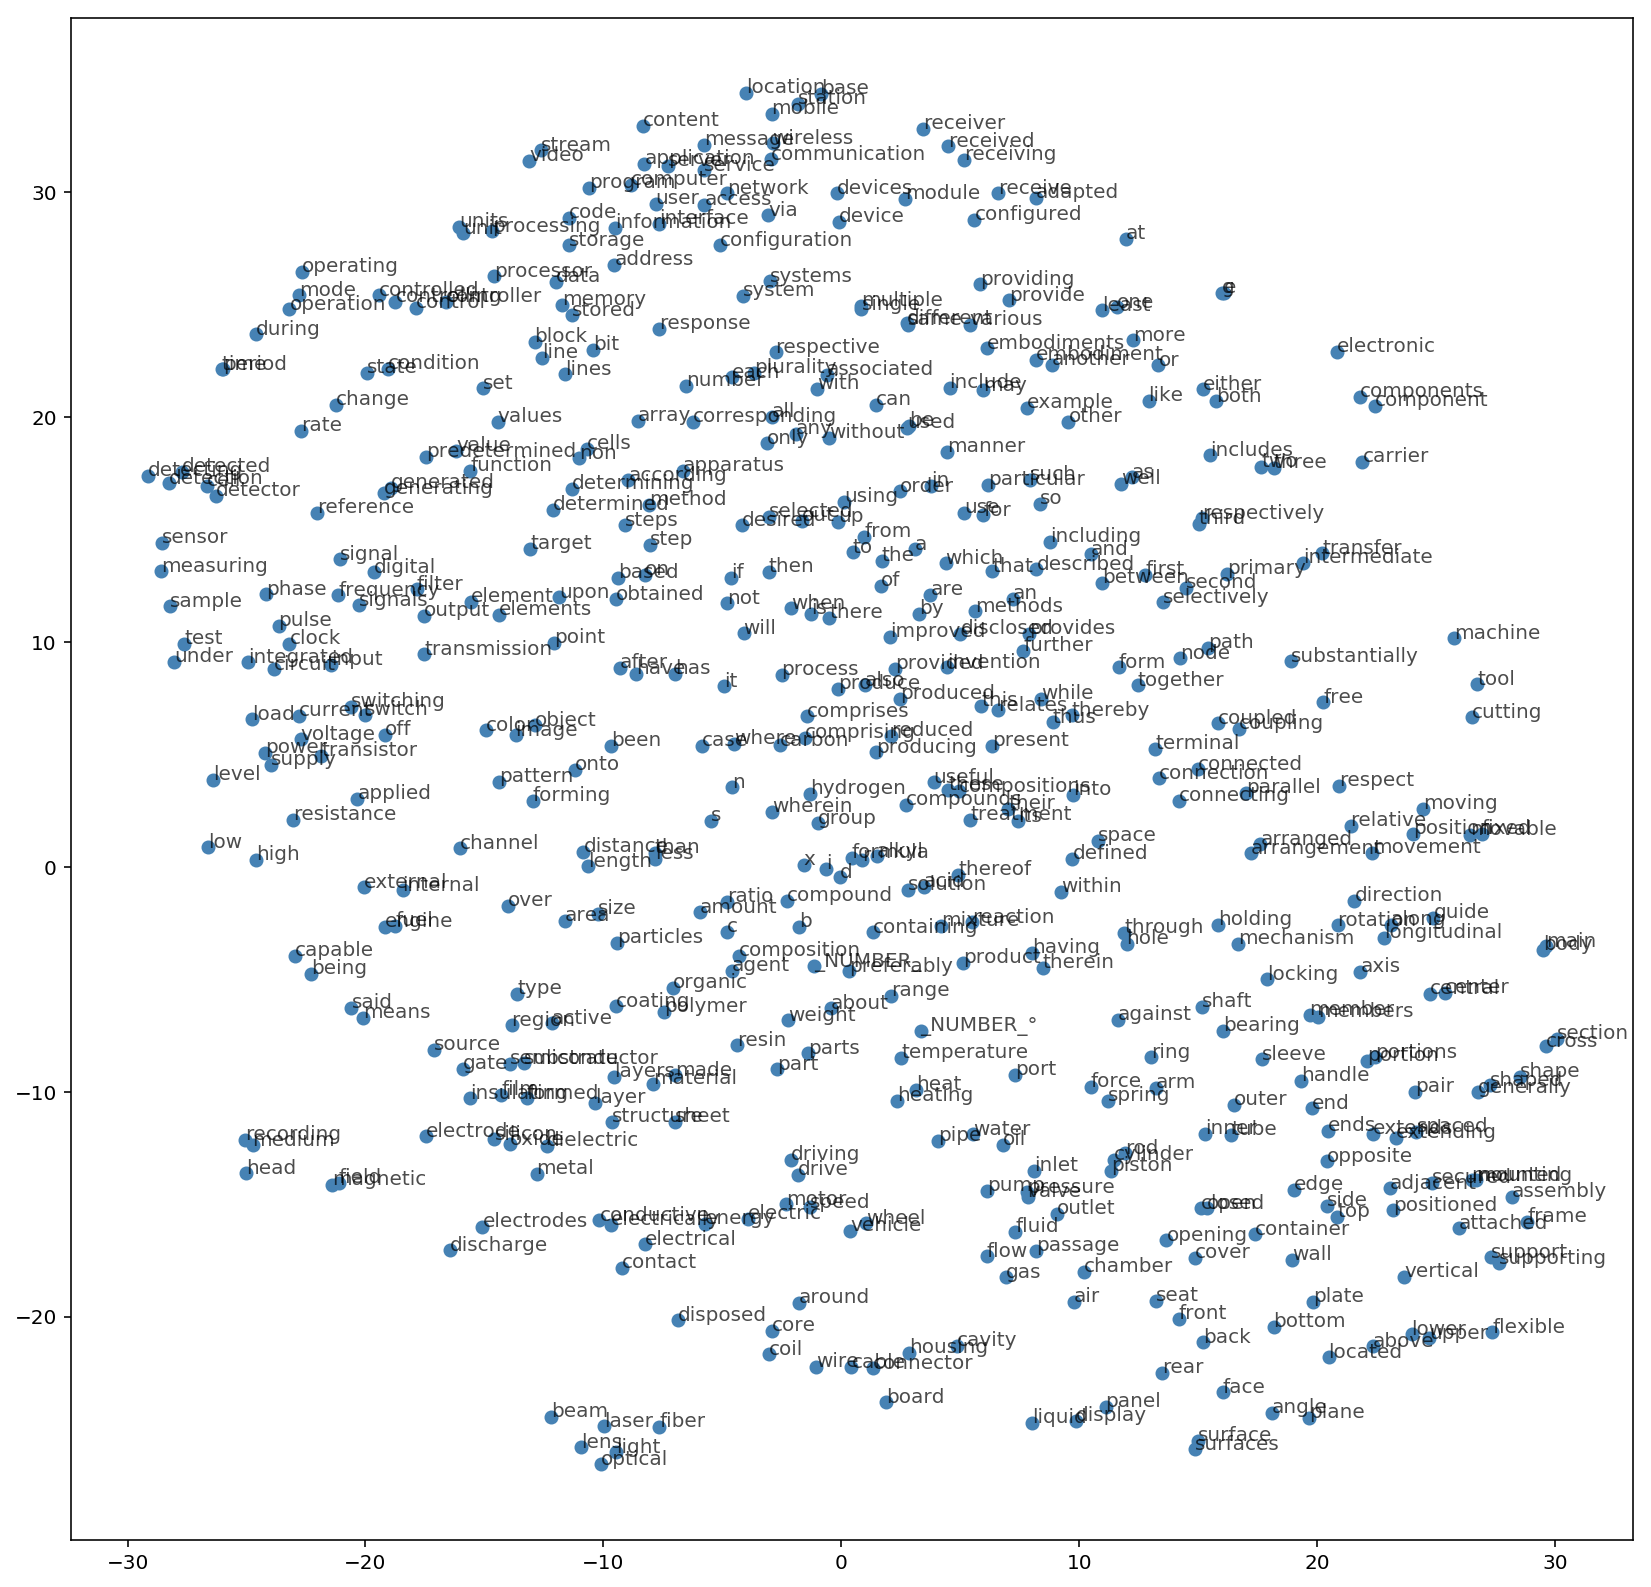

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

w2v_runtime.visualize_embeddings(500)

## Patent Landscape Expansion

This section of the notebook creates an instance of the `PatentLandscapeExpander`, which accesses a BigQuery table of patent data to do the expansion of a provided seed set and produces each expansion level as well as the final training dataset as a Pandas dataframe.

In [4]:
from expansion import PatentLandscapeExpander

expander = PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


This does the actual expansion and displays the head of the final training data dataframe.

In [5]:
training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.derive_training_data_from_seeds(seed_file)
training_data_full_df.head()

Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 1459 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (1459, 1), to patents._l1_tmp
Completed loading temp table.
Shape of L1 expansion: (1906, 3)
Got 9652 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (9652, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (7221, 3)
Size of union of [Seed, L1, and L2]: 7667
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (7667, 1), to patents.antiseed_tmp
Completed loading temp table.
Loading training data text from (15301, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (15301, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into training data.


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,2003123084,US-2003123084-A1,22484855,19980824,Virtual printer with asynchronous job and devi...,A flexible and extensible virtual printer arch...,unused,unused,"US-5050100-A,US-5050100-A,US-5050100-A,US-5157...","G06F3/1259,G06F3/1288,G06F3/1207,G06F3/1259,G0...",AntiSeed
1,5861009,US-5861009-A,25496799,19971021,Implantable cardiac stimulator with rate-adapt...,An implantable device for providing pacing and...,unused,unused,"US-4830006-B1,US-4830006-B1,US-4830006-B1,US-4...","A61N1/365,A61N1/3704,A61N1/3962,A61N1/365,A61N...",AntiSeed
2,9473754,US-9473754-B2,51866007,20131031,Dynamic light distribution system and apparatus,A system and apparatus for dynamically distrib...,unused,unused,"US-5774604-A,US-5774604-A,US-5774604-A,US-5774...","G03B21/206,G02B6/3598,G02B26/0883,H04N9/3182,G...",AntiSeed
3,7234643,US-7234643-B2,34400902,20031031,Microelectronic circuit for activation or deac...,The invention concerns a microelectronic circu...,unused,unused,"US-5854560-A,US-5862390-A,US-5923183-A,US-2004...","G06K7/0013,G06K7/0013,G06K7/0013,G06K7/0013,G0...",AntiSeed
4,4170873,US-4170873-A,25198314,19770720,Lubrication system,An oil supply system for pumping oil to the ma...,unused,unused,"CA-702551-A,CA-702551-A,US-2611440-A,US-261144...","F01D25/18,F01D25/20,F01D25/18,F01D25/20,F01D25...",AntiSeed


In [6]:
training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]

In [7]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    240
title_text            240
abstract_text         240
claims_text           240
description_text      240
ExpansionLevel        240
refs                  240
cpcs                  240
dtype: int64


Anti-Seed/Negative examples:
publication_number    9814
title_text            9814
abstract_text         9814
claims_text           9814
description_text      9814
ExpansionLevel        9814
refs                  9814
cpcs                  9814
dtype: int64


## Preparing / Transforming Training Data

The following takes the input landscape training dataframe and transforms it into a format readable by TensorFlow and Keras.

In [8]:
import importlib
import train_data
import tokenizer

importlib.reload(tokenizer)
importlib.reload(train_data)

td = train_data.LandscapeTrainingData(training_df, w2v_runtime)
td.prepare_training_data(
    training_df.ExpansionLevel,
    training_df.abstract_text,
    training_df.refs,
    training_df.cpcs,
    0.8,
    50000,
    500)


Using TensorFlow backend.


No Keras tokenizer supplied so using vocab size (50000) and series to build new one
No Keras tokenizer supplied so using vocab size (500) and series to build new one
Randomizing training data
Creating NumPy arrays for train/test set out of randomized training data.
Train (embed) data shapes: train: (8043,), train labels shape: (8043,)
Test (embed) data shape: (2011,), test labels shape: (2011,)
doc lengths for embedding layer: median: 102, mean: 104.71043143105807, max: 497
Using sequence length of 497 to pad LSTM sequences.
Training data ready.


In [9]:
def show_instance_details(training_data, training_data_series, idx):
    print('\nOriginal: {}\nTokenized: {}\nIntegerized: {}\nLabelIntegerized: {}'.format(
        training_data_series[idx],
        training_data.to_text(training_data.prepped_embedding_train[idx]),
        training_data.prepped_embedding_train[idx],
        training_data.prepped_labels[idx]))

show_instance_details(td, td.series_text_to_embed, 0)



Original: A flexible and extensible virtual printer architecture is provided. According to one aspect of the present invention final status associated with a presentation job (e.g., a fax job or a print job) is made available to an output server. One or more host processing threads or processes are spawned for each new presentation job received by the output server. Then, the presentation job is submitted to a presentation device for which the presentation job is destined by way of an instance of a wrapper process that is capable of communicating bi-directionally with the presentation device. After submitting the presentation job, a host job status thread or process waits for status pertaining to the presentation job. Ultimately, a final status associated with the presentation job is received by the wrapper process and the wrapper process reports the final status to the host job status thread or process. According to another aspect of the present invention, job and device status may b

In [10]:
# finding a positive example and showing some details
print_idx = 0
for row in td.trainY:
    if td.trainY[print_idx] == 0:
        break
    else:
        print_idx += 1

print('Using index {}.'.format(print_idx))
print(td.trainEmbedX[print_idx])
print(td.to_text(td.trainEmbedX[print_idx]))
print(td.trainY[print_idx])

Using index 6.
[1, 2124, 3836, 10, 1, 1065, 2492, 67, 1065, 2492, 67, 24, 1, 1065, 588, 1, 595, 244, 4, 1214, 123, 406, 8, 3967, 129, 970, 12, 1, 1389, 3, 1, 2513, 9, 986, 123, 15, 595, 41, 3967, 129, 732, 2, 1019, 3884, 5, 1757, 12, 445, 178, 3, 150, 2044, 28, 10, 1, 660, 453, 304, 6, 1065, 588, 219, 10, 588, 150, 304, 178, 588, 5, 1291, 75, 150, 588, 453, 44, 2, 71, 178, 588, 65, 2918, 15, 3, 660, 15, 453, 44, 2, 150, 588, 6, 219, 588, 453, 304, 411, 13, 1596, 117, 585, 1969, 4, 564, 123, 3884, 15, 3669, 15, 150, 588, 150, 44]
a hair dryer with a vapor ejection means vapor ejection means includes a vapor nozzle a tank adapted to contain liquid therein an evaporation chamber heated by a heater and a feeder for feeding liquid from tank into evaporation chamber formation of hot drops is prevented by longitudinal inner and outer nozzles each with a separate discharge ends in vapor nozzle both with nozzle outer ends inner nozzle is longitudinally within outer nozzle discharge end of said 

# Train Model

The following cells specify hyperparameters, the neural network architecture (using Keras) and actually trains and tests the model.

The model is generally composed of:
* sequential word embeddings from the patent Abstract of each training instance
* references one-hot encoded into a fully-connected layer
* CPC codes one-hot encoded into a fully-connected layer
* the above three layers concatenated into a final fully-connected layer
* a final, single sigmoid layer with the classification result


### Hyperparameters

In [11]:
batch_size = 32
dropout_pct = 0.2

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128


### Build the Deep Neural Network

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, ELU
from keras.layers import LSTM, Conv1D, MaxPooling1D, Merge
from keras.layers.merge import concatenate
from keras.layers.core import Dropout
from keras_metrics import precision, recall, f1score

print('Building model graph...')

refs = Sequential()
refs.add(
    Dense(
        256,
        input_dim=td.trainRefsOneHotX.shape[1],
        name='refs',
        activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())
refs.add(Dense(64, activation=None))
refs.add(Dropout(dropout_pct))
refs.add(BatchNormalization())
refs.add(ELU())

cpcs = Sequential()
cpcs.add(
    Dense(
        32,
        input_dim=td.trainCpcOneHotX.shape[1],
        name='cpcs',
        activation=None))
cpcs.add(Dropout(dropout_pct))
cpcs.add(BatchNormalization())
cpcs.add(ELU())

deep = Sequential()

embedding_layer = Embedding(td.w2v_runtime.embedding_weights.shape[0],
                            td.w2v_runtime.embedding_weights.shape[1],
                            weights=[td.w2v_runtime.embedding_weights],
                            #input_length=sequence_len,
                            trainable=False,
                            name='embed')
deep.add(embedding_layer)
'''
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
'''
deep.add(LSTM(
    lstm_size,
    dropout=dropout_pct,
    recurrent_dropout=dropout_pct,
    return_sequences=False,
    name='LSTM_1'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name='LSTM_2'))
deep.add(Dense(300, activation=None))
deep.add(Dropout(dropout_pct))
deep.add(BatchNormalization())
deep.add(ELU())


#model = Sequential()
model = deep
#model.add(concatenate([wide, deep], axis=1))
#model.add(Merge([cpcs, deep], mode='concat', concat_axis=1))
#model.add(Dense(64, activation=None))
#model.add(Dropout(dropout_pct))
#model.add(BatchNormalization())
#model.add(ELU())
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])

print('Done building graph.')

Build model...


### Train / Fit the Network

In [36]:
print('Train...')

model.fit(x={
            'refs_input': td.trainRefsOneHotX,
            'embed_input': td.padded_train_embed_x,
            'cpcs_input': td.trainCpcOneHotX},
          y=td.trainY,
          batch_size=batch_size,
          epochs=5,
          validation_data=(
              {
                  'refs_input': td.testRefsOneHotX,
                  'cpcs_input': td.testCpcOneHotX,
                  'embed_input': td.padded_test_embed_x},
              td.testY))


Train...
Train on 8043 samples, validate on 2011 samples
Epoch 1/5
8043/8043 [==============================] - 156s - loss: 0.1464 - acc: 0.9595 - precision: 0.9806 - recall: 0.9778 - fmeasure: 0.9772 - val_loss: 0.1122 - val_acc: 0.9707 - val_precision: 0.9707 - val_recall: 1.0000 - val_fmeasure: 0.9849
Epoch 2/5
8043/8043 [==============================] - 157s - loss: 0.0773 - acc: 0.9797 - precision: 0.9840 - recall: 0.9956 - fmeasure: 0.9896 - val_loss: 0.1001 - val_acc: 0.9826 - val_precision: 0.9853 - val_recall: 0.9969 - val_fmeasure: 0.9909
Epoch 3/5
8043/8043 [==============================] - 156s - loss: 0.0576 - acc: 0.9846 - precision: 0.9882 - recall: 0.9962 - fmeasure: 0.9920 - val_loss: 0.0632 - val_acc: 0.9816 - val_precision: 0.9873 - val_recall: 0.9939 - val_fmeasure: 0.9904
Epoch 4/5
8043/8043 [==============================] - 149s - loss: 0.0521 - acc: 0.9871 - precision: 0.9896 - recall: 0.9973 - fmeasure: 0.9933 - val_loss: 0.0455 - val_acc: 0.9891 - val_preci

### Evaluate the Network on the Test Set

In [37]:
score, acc, p, r, f1 = model.evaluate(
    x={
        'refs_input': td.testRefsOneHotX,
        'cpcs_input': td.testCpcOneHotX,
        'embed_input': td.padded_test_embed_x
    },
    y=td.testY,
    batch_size=batch_size)

print('')
print('Test score: {:.4f}'.format(score))
print('Test accuracy: {:.4f}'.format(acc))
print('Test p/r (f1): {:.2f}/{:.2f} ({:.2f})'.format(p, r, f1))


2011/2011 [==============================] - 8s     

Test score: 0.0199
Test accuracy: 0.9970
Test p/r (f1): 1.00/1.00 (1.00)


------

# Inference

*NOTE*: the below inference code assumes you've already trained a model _in the currently active kernel_ such that the following variables are already set:
* `model` is the Keras-trained DNN
* `l1_patents_df` is the dataframe returned by the PatentLandscapeExpander

Future iterations will save model checkpoints and allow saving off models and then loading them later just for inference.

### Load Inference Data

This randomly selects a subset of the L1 patents (that we got from reference and CPC expansions) and loads the details (text, CPCs, refs, etc.) from BigQuery.

In [16]:
subset_l1_pub_nums = l1_patents_df[['publication_number']].sample(frac=.20).reset_index(drop=True)
subset_l1_pub_nums.head()

,publication_number
0,US-4659907-A
1,US-6584985-B2
2,US-4258408-A
3,US-6868579-B2
4,US-4002951-A


In [49]:
#training_df[training_df.abstract_text.str.contains('learn') & training_df.abstract_text.str.contains('machine')]
#training_df[training_df.abstract_text.str.contains('machine')]

l1_texts = expander.load_training_data_from_pubs(subset_l1_pub_nums)
#l1_texts['label'] = 'Seed'
print(l1_texts.shape)
l1_texts.head()


Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (381, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
(311, 10)


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs
0,2013160316,US-2013160316-A1,48653181,20111128,Hair drying device,A hair drying device including a tube with sel...,unused,unused,"EP-0284690-A2,EP-0284690-A2,EP-0284690-A2,EP-0...","A45D20/00,A45D20/00,A45D20/16,A45D20/12,A45D20..."
1,4023928,US-4023928-A,27015704,19730913,Catalytic fume control device,An electric lamp bulb or electric resistance c...,unused,unused,"US-1678778-A,US-1901038-A,US-2668993-A,US-3001...","A61L9/03,A61L9/03,A61L9/03,A61L9/03,A61L9/03,A..."
2,4328818,US-4328818-A,24732138,19760427,Hand held hair dryer,A domestic hair dryer comprises an axisymetric...,unused,unused,"US-2678376-A,US-2678376-A,US-2817000-A,US-2817...","A45D20/10,A45D20/50,A45D20/10,A45D20/50,A45D20..."
3,6393718,US-6393718-B1,26913827,20000719,Hand held hair dryer,A hand-held hair dryer which includes a negati...,unused,unused,"US-4196343-A,US-4196343-A,US-4258408-A,US-4258...","A45D2200/202,A45D20/12,A45D2200/202,A45D20/12,..."
4,2005108889,US-2005108889-A1,34594761,20031017,Hair dryer attachment,An attachment to a hair dryer is provided incl...,unused,unused,"US-3892247-A,US-3892247-A,US-5612849-A,US-5612...","A45D2200/202,A45D20/122,A45D2200/202,A45D20/12..."


#### Classification of L1

In [93]:

l1_subset = l1_texts[:100][['publication_number', 'abstract_text', 'refs', 'cpcs']]

padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    td.prep_for_inference(l1_subset.abstract_text, l1_subset.refs, l1_subset.cpcs)

predictions = model.predict(
    {
        'embed_input': padded_abstract_embeddings,
        'cpcs_input': cpc_one_hot,
        'refs_input': refs_one_hot
    })

l1_subset['score'] = pd.DataFrame(predictions, columns=['score'])['score']

In [106]:

l1_subset['has_hair'] = l1_subset.abstract_text.str.lower().str.contains('hair')
l1_subset['has_dry'] = l1_subset.abstract_text.str.lower().str.contains('dry')
l1_subset[(l1_subset.score > 0.5) & (l1_subset.has_hair == False) & (l1_subset.has_dry == False)].abstract_text.iloc[0]


'An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or ca

#### Ad-hoc classification
If you want to experiment with ad-hoc classification of data, edit the fields below for abstract text, references, and CPC codes to see how it influences the model's output. Somewhat counter-intuitively, a score closer to 0 means more likely to be an instance of the seed class (e.g., more likely to be about 'hair dryers').

In [72]:
# A conditioner infuser cartridge for use with a dryer attachment having an attachment end for engagement with a hair dryer barrel, an opposite air outlet end and a perforated portion between the ends having at least one air intake, the cartridge configured for engagement near the attachment end and including a conditioner element constructed and arranged for retaining a supply of vaporizable conditioner and a support frame receiving the conditioner element and securing same in the attachment.

adhoc_abstracts = pd.Series(
    [
        'A hand-held hair dryer.',
    ])
adhoc_refs = pd.Series(
    [
        '',
    ])
adhoc_cpcs = pd.Series(
    [
        '',
    ])

padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    td.prep_for_inference(adhoc_abstracts, adhoc_refs, adhoc_cpcs)

model.predict(
    {
        'embed_input': padded_abstract_embeddings,
        'cpcs_input': cpc_one_hot,
        'refs_input': refs_one_hot
    })


array([[ 0.02420646]], dtype=float32)

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def binary_prediction_idx(score):
    if score < .5:
        return 0
    return 1

def predictions_for_report(patent_model, validX, validY):
    target_names = ['seed', 'antiseed']

    prediction_scores = patent_model.predict(validX)
    predictions = []
    actual_y = []

    for idx in range(0, len(prediction_scores)):
        prediction = prediction_scores[idx]
        actual = validY[idx]
        predictions.append(binary_prediction_idx(prediction[0]))
        actual_y.append(actual)

    return predictions, actual_y, target_names


In [41]:
import pandas as pd
l1_texts_subset = l1_texts.abstract_text[:10000]
l1_texts_subset.reset_index(drop=True, inplace=True)
l1_texts_subset.loc[len(l1_texts_subset)-1] = 'this abstract is about something entirely boring'

l1_labels_subset = l1_texts.label[:10000]
l1_labels_subset.reset_index(drop=True, inplace=True)
l1_labels_subset.loc[len(l1_texts_subset)-1] = 'AntiSeed'

print('Prepping series (tokenization etc.) for training.')
l1_x, l1_y = prep_series_for_training(w2v_runtime, l1_texts_subset, l1_labels_subset)
l1_x = np.array(l1_x)
l1_y = np.array(l1_y)

print('Padding sequences.')
# Convert text idx into padded sequences
l1_x = sequence.pad_sequences(
        l1_x, maxlen=sequence_len, padding='pre', truncating='post')
# Converting labels to binary vectors
#l1_y = to_categorical(l1_y, nb_classes=2)

print('Making predictions')
l1_preds, actual_l1_y, target_names = predictions_for_report(model, l1_x, l1_y)

cr = classification_report(l1_preds, actual_l1_y, target_names=target_names)
cm = confusion_matrix(l1_preds, actual_l1_y)
print(cr)
print(cm)
#l1_texts_subset

Prepping series (tokenization etc.) for training.
Padding sequences.
Making predictions
             precision    recall  f1-score   support

       seed       0.31      1.00      0.47      3070
   antiseed       1.00      0.00      0.00      6930

avg / total       0.79      0.31      0.14     10000

[[3070    0]
 [6929    1]]


In [120]:
#print(l1_preds)
l1_preds_df = pd.DataFrame(l1_preds, columns=['PredictionIdx'])
l1_preds_df['Prediction'] = l1_preds_df.PredictionIdx.apply(label_id_to_text)
l1_preds_df

,PredictionIdx,Prediction
0,1,antiseed
1,1,antiseed
2,1,antiseed
3,0,seed
4,1,antiseed
5,1,antiseed
6,1,antiseed
7,1,antiseed
8,1,antiseed
9,1,antiseed


In [114]:
l1_texts_subset[1]

'The present invention relates to a method for detecting fetal Down syndrome (Trisomy 21), trisomy 13, trisomy 18 and other chromosomal anomalies during prenatal screening by analyzing a dried blood sample from a pregnant woman. More particularly the present invention relates to a method for improving detection efficiency in screening for the anomalies by measuring the amount of the free beta human chorionic gonadotropin (HCG) and nicked or fragmented or aberrant forms of free beta (HCG), all of which are referenced throughout this application as free beta (HCG) in dried blood samples from pregnant women.'

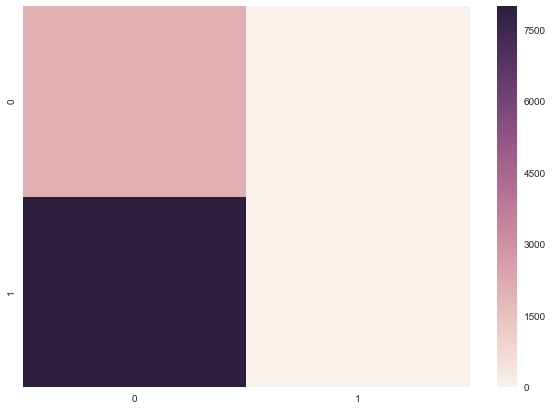

In [93]:
%matplotlib inline

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(cm_df)

In [23]:
import pandas as pd

def make_prediction(patent_model, text, expected_label, max_seq_len, mask_idx=0):
    inf_series = pd.Series([text])
    lab_series = pd.Series([label])

    prepped_train, prepped_labels = \
        prep_series_for_training(
            w2v_runtime=w2v_runtime,
            labels_series=lab_series,
            raw_series_text=inf_series)

    # make sure we have the correct sequence length
    #infX = pad_sequences(prepped_train, maxlen=max_seq_len, value=mask_idx)
    infX = sequence.pad_sequences(
        prepped_train, maxlen=sequence_len, padding='pre', truncating='post')
    #prepped_train = np.array(prepped_train)

    # actually make prediction
    prediction = patent_model.predict(infX)

    return prediction


In [34]:
model.save(filepath='checkpoints/keras_model.ckpt')

In [33]:
text = 'a really boring title that is super long and has nothing to do with the topic that im interested in. but has a bit of stuff about artificial neural networks and things i haven\'t heard of?'
text = 'three dimensional mapping'
#text = l1_texts_subset[10]
label = 'Seed'
prediction = make_prediction(model, text, expected_label=label, max_seq_len=sequence_len)
print('Text: {}'.format(text))
#print('Tokenized/Integerized: {}'.format(prepped_train))
#print('Padded: {}'.format(infX))
print('Prediction: {}'.format(prediction))
print('Predicted Label: {}, Actual Label: {}'.format(label_id_to_text(binary_prediction_idx(prediction)), label))


Text: three dimensional mapping
Prediction: [[ 0.98487407]]
Predicted Label: antiseed, Actual Label: Seed


In [302]:
#oldidx = print_idx
#print_idx = oldidx
#print(model.predict([trainX[print_idx]]))
#tensor_label_to_text(trainY[print_idx])